# scQUEST Tutorial on AML Patients

In [1]:
import scQUEST as scq
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
fpath = Path(
    "/Users/art/Downloads/Datasets/Levine_CyTOF_AML_AnnotatedCellTypes/ad_annotated_cell_types.h5ad"
)
assert fpath.is_file()
ad_anno = anndata.read_h5ad(fpath)
ad_anno

AnnData object with n_obs × n_vars = 96381 × 39
    obs: 'celltype', 'complexcelltype', 'patient', 'ncells'
    var: 'channel', 'marker', 'usedformanualannotation', 'usedforPhenoGraphclustering'
    uns: 'fcs_header'

In [3]:
fpath = Path(
    "/Users/art/Downloads/Datasets/Levine_CyTOF_AML_Healthy_vs_AML/ad_healty_aml.h5ad"
)
assert fpath.is_file()
ad_pat = anndata.read_h5ad(fpath)
ad_pat

AnnData object with n_obs × n_vars = 873106 × 43
    obs: 'patient', 'tissue', 'ncells'
    var: 'channel', 'marker', 'usedforPhenoGraphclustering'
    uns: 'fcs_header'

In [4]:
ad_anno.var.usedforPhenoGraphclustering = ad_anno.var.usedforPhenoGraphclustering.map(
    lambda x: x == "yes"
)
ad_anno.var.usedformanualannotation = ad_anno.var.usedformanualannotation.map(
    lambda x: x == "yes"
)

ad_pat.var.usedforPhenoGraphclustering = ad_pat.var.usedforPhenoGraphclustering.map(
    lambda x: x == "yes"
)

## Normalise counts

In [5]:
(ad_pat.obs.tissue == "healthy").sum()

183414

In [6]:
markers = set(ad_pat.var.marker).intersection(set(ad_anno.var.marker))
markers

{'CD117',
 'CD11b',
 'CD123',
 'CD15',
 'CD19',
 'CD3',
 'CD33',
 'CD34',
 'CD38',
 'CD41',
 'CD44',
 'CD45',
 'CD47',
 'CD64',
 'CD7',
 'Cell_length',
 'DNA1',
 'DNA2',
 'Time',
 'Viability'}

In [84]:
# normalisation according to paper

# TODO subset to markers that intersect

# ad_pat.layers['paper_norm'] = ad_pat.X.copy()
# ad_anno.layers['paper_norm'] = ad_anno.X.copy()

# ad = ad_pat[ad_pat.obs.tissue == 'healthy']
# thres = np.quantile(ad.X, .995, axis=0)
# for i, b in enumerate(ad.var.usedforPhenoGraphclustering):
#     if b:
#         ad_pat.layers['paper_norm'][:, i] = ad_pat.X[:, i] / thres[i]
#         ad_anno.layers['paper_norm'][:, i] = ad_anno.X[:, i] / thres[i]

In [85]:
ad = ad_pat[ad_pat.obs.tissue == "healthy"]

In [92]:
ad = ad_anno
ad.shape

(96381, 39)

In [93]:
X = ad.X.copy()
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)

# add transformed data to a separate layer in the annData object
ad.layers["arcsinh"] = X

In [94]:
markers = ["CD" + str(i) for i in [34, 38, 117, 123, 33, 47, 45, 15, 7, 19, 64, 3]]
markers = markers[:3] + ["HLA-DR"] + markers[3:]
sad = ad[:, ad.var.marker.isin(markers)]

In [112]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

In [117]:
X = sad.X
minmax.fit(X)
minmax.data_max_ = np.quantile(X, 0.995, axis=0)
X = minmax.transform(X)

X = pd.DataFrame(X, columns=sad.var.marker, index=sad.obs.celltype)
X = X.groupby("celltype").agg("mean")
X = X[markers]
Xmean = X.copy()

In [118]:
X = sad.layers["arcsinh"]
minmax.fit(X)
minmax.data_max_ = np.quantile(X, 0.995, axis=0)
X = minmax.transform(X)

X = pd.DataFrame(X, columns=sad.var.marker, index=sad.obs.celltype)
X = X.groupby("celltype").agg("mean")
X = X[markers]
XarcsinhMean = X.copy()

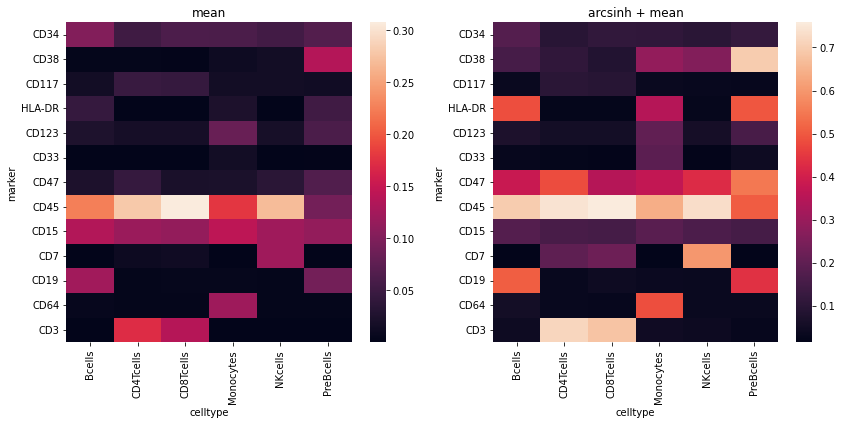

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = sns.heatmap(Xmean.T, ax=axs[0])
ax = sns.heatmap(XarcsinhMean.T, ax=axs[1])
for ax, title in zip(axs, ["mean", "arcsinh + mean"]):
    ax.set_title(title)
fig.tight_layout()

In [104]:
X = sad.layers["arcsinh"]
X = pd.DataFrame(X, columns=sad.var.marker, index=sad.obs.celltype)
X = X.groupby("celltype").agg("mean")
X = X[markers]
X

marker,CD34,CD38,CD117,HLA-DR,CD123,CD33,CD47,CD45,CD15,CD7,CD19,CD64,CD3
celltype,,,,,,,,,,,,,
Bcells,0.327711,0.989814,0.022242,3.379473,0.151868,0.107430,2.416411,5.595470,0.226154,0.036623,2.238480,0.193583,0.231779
CD4Tcells,0.144730,0.690508,0.174041,0.091958,0.100873,0.059274,3.043263,5.825321,0.191651,1.184455,0.084487,0.078564,4.814879
CD8Tcells,0.185324,0.506332,0.158922,0.103649,0.098512,0.052214,2.191668,5.908257,0.181987,1.364193,0.132012,0.070522,4.583318
Monocytes,0.181088,1.931249,0.023007,2.402068,0.544306,1.022279,2.329208,5.310382,0.241843,0.040609,0.110949,2.154088,0.255818
NKcells,0.153311,1.731991,0.018252,0.109850,0.107161,0.056925,2.692873,5.760594,0.201567,3.751568,0.096506,0.091871,0.206737
PreBcells,0.197860,4.721648,0.011721,3.472800,0.406044,0.180743,3.473438,4.605569,0.180232,0.036190,1.933198,0.100331,0.128360


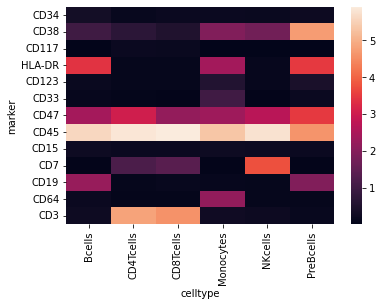

In [105]:
fig, ax = plt.subplots()
ax = sns.heatmap(X.T, ax=ax)